# Profiler vos programmes avec Python


![Stop watch](stopwatch.jpg "Pixabay https://pixabay.com/illustrations/stopwatch-time-treadmill-race-259303/")

Ce TP propose des exercices présentant quelques librairies Python permettant de profiler votre code source afin d'essayer d'identifier les sources de ralentissements de vos programmes.

En matière de [profilage](https://fr.wikipedia.org/wiki/Profilage_de_code), Python propose plusieurs librairies en standard:

* timeit  
  https://docs.python.org/3/library/timeit.html 
* cProfile  
  https://docs.python.org/3/library/profile.html
* Trace  
  https://docs.python.org/3/library/trace.html#module-trace  
* FaultHandler  
  https://docs.python.org/3/library/faulthandler.html
  
D'autres librairies issues de la communauté sont aussi disponibles, dont:

* [PyCallGraph](http://pycallgraph.slowchop.com/en/master/) et son fork [PyCallGraph2](https://github.com/daneads/pycallgraph2#readme#readme) qu'il est conseillé car la première version n'est plus vraiment maintenue.

* [pyprof2calltree](https://github.com/pwaller/pyprof2calltree/#readme) qui permet de collecter des traces pStats de *cProfile* pour les visualiser avec [KCachegrind](https://kcachegrind.github.io/html/Home.html)

* Et nous en verrons quelques autres

## Types de profiler

On dénote en général 2 types de profileurs:

* Les profileurs événementiels ou déterministes (tracing profiler), qui enregistrent toutes les actions qui se passent dans le programme et peuvent fournir beaucoup de statistiques très précises.   
Ils présentent l'inconvénient d'être très gourmands en ressources et peuvent ralentir considérablement le programme principal, ce qui les rend parfois inutilisables.

* Les profileurs statistiques qui prélèvent à intervalles réguliers des informations sur votre programme.  
  Beaucoup moins gourmands en ressources ils ne fournissent pas une vue complète du programme et peuvent manquer des éléments si ceux-ci se produisent en dehors de leurs intervalles de mesures.

## Time It

La librairie timeit est relativement facile à utiliser: vous lui passer sous forme de texte, le code à exécuter, plus quelques pramètres comme le nombre de fois que ce code doit être lancé ou encore les variables de départ, et elle exécute votre code pour vous retourner le temps mesuré.

Un exemple valant mieux qu'un long discours, essayons avec la [suite de Padovan](https://fr.wikipedia.org/wiki/Suite_de_Padovan) en version récursive, histoire de ne pas reprendre l'exemple plus classique qu'est *Fibonacci* !

In [1]:
def padovan(n):
    # assert n >= 0
    
    if n <= 2:
        return 1
    else:
        return padovan(n - 2) + padovan(n - 3)
    
for n, value in enumerate((1, 1, 1, 2, 2, 3, 4, 5, 7, 9, 12)):
    assert padovan(n) == value
    
print("ok")

ok


In [2]:
import timeit

In [3]:
# timeit.timeit(stmt="padovan(20)") # Erreur

```python
timeit.timeit(stmt="padovan(20)") # Erreur
```

```
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-132-6cd060fb81bb> in <module>
----> 1 timeit.timeit(stmt="padovan(20)") # Erreur

~/anaconda/lib/python3.7/timeit.py in timeit(stmt, setup, timer, number, globals)
    230            number=default_number, globals=None):
    231     """Convenience function to create Timer object and call timeit method."""
--> 232     return Timer(stmt, setup, timer, globals).timeit(number)
    233 
    234 def repeat(stmt="pass", setup="pass", timer=default_timer,

~/anaconda/lib/python3.7/timeit.py in timeit(self, number)
    174         gc.disable()
    175         try:
--> 176             timing = self.inner(it, self.timer)
    177         finally:
    178             if gcold:

~/anaconda/lib/python3.7/timeit.py in inner(_it, _timer)

NameError: name 'padovan' is not defined
```

La fonction *timeit* ne connaît pas les fonctions de votre programme, il convient de les lui transmettre via le paramètre **globals**. Ce paramètre attend un dictionnaire dont les clefs sont les noms de vos objets.  


In [4]:
timeit.timeit(stmt="padovan(20)", globals={'padovan' : padovan})

24.584196265001083

Ce temps peut sembler bien long, en effet, *timeit* exécute par défaut un million de fois le code demandé. Et retourne le temps total.

In [5]:
repeat = 100000
total_time = timeit.timeit(stmt="padovan(20)", number=repeat, globals=globals())
print("Durée totale en secondes pour %s exécutions : %08.06f" % (repeat, total_time))
print( f"Durée moyenne en secondes: {total_time/repeat:08.06f}")

Durée totale en secondes pour 100000 exécutions : 2.419350
Durée moyenne en secondes: 0.000024


**NB** : Dans l'exemple ci-dessus nous utilisons la fonction python [globals](https://docs.python.org/3.7/library/functions.html#globals) qui retourne le dictionnaire des objets globaux pour initialiser le paramètre de *timeit* du même nom, c'est bien plus pratique

Le temps moyen n'est pas forcément un bon critère: lors de multiples exécutions la durée peut varier d'une fois à l'autre de manière significative selon la charge de votre système, surtout sur de petits délais comme celui-ci.

Dans ce cas la fonction repeat, qui répète plusieurs fois les *number* mesures et pour chaque répétition retourne le meilleur temps de ces mesures peut s'avérer être une meilleure option en ne conservant que la valeur minimale de la liste résultat:

In [6]:
times = timeit.repeat(stmt="padovan(20)", globals=globals(), repeat=10, number=100)
print("Meilleurs temps des 10 séries de 100 mesures: ")
print(times)
print("\nMeilleur temps pour les 100 mesures:", min(times))

Meilleurs temps des 10 séries de 100 mesures: 
[0.002551789002609439, 0.00268129599862732, 0.002631343995744828, 0.002532539001549594, 0.002732001004915219, 0.0028593390015885234, 0.0025432030015508644, 0.0027570079982979223, 0.0026723789997049607, 0.0026331900007789955]

Meilleur temps pour les 100 mesures: 0.002532539001549594


Attention, chaque mesure reste un temps cumulé.

Pourquoi de nombreux exemples de profiling utilisent des suites numériques à double récursivité ?  

Parce que leur code est très consommateur de temps : chaque appel lance 2 autres appels, qui à leur tour en lancent 2 autres, et ainsi de suite. Pour calculer padovan(7), 8 appels de sous fonctions sont réalisés.



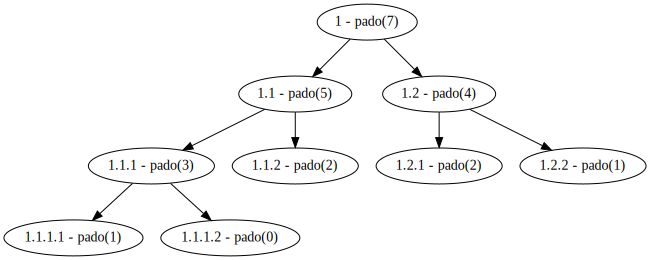

In [7]:
from graphviz import Digraph
"""
To install graphviz

bash$ pip install graphviz

or

bash$ conda install graphviz

Check that the file 'dot' is in your path

bash$ which dot
/home/user/anaconda/bin/dot


Under Windows or Mac you may need to install the graphviz binary from http://graphviz.org/download/
And be sure to set dot.exe in your path

C:> set PATH=%PATH%;c:/path/to/dot.exe
"""

dot = Digraph(comment='Padovan Tree', format='svg')

def pado(n, g, node_name=None):
    
    if not node_name:
        node_name = "1"
        label = "%s - pado(%s)" % (node_name, n)
        g.node(node_name, label)
    
    
    if n > 2:
        s1 = node_name + ".1"
        s2 = node_name + ".2"

        label = "%s - pado(%s)" % (s1, n - 2)
        g.node(s1, label)

        label = "%s - pado(%s)" % (s2, n - 3)
        g.node(s2, label)
        g.edge(node_name, s1)
        g.edge(node_name, s2)

    return 1 if n <= 2 else pado(n - 2, g, node_name=s1) + pado(n - 3, g, node_name=s2)

pado(7, dot)
dot  # dot.view()
    
    

L'ordre de grandeur du nombre d'appels imbriqués pour `padovan(n)` est `2**(n-1)`.  
Cette implémentation utilisant une double récursivité est particulièrement mauvaise d'un point de vue performances puisqu'elle génère des temps de calculs exponentiels.

Juste pour le plaisir, voici une autre manière un peu plus générique de générer le graphe des appels en utilisant les modules *traceback* et *inspect* de Python:

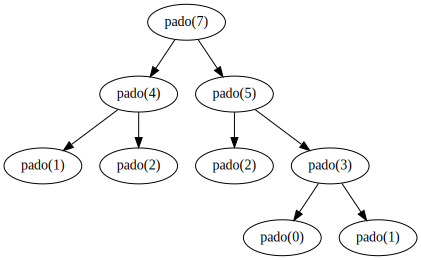

In [8]:
import traceback
import inspect 

def pado(n, first=True):
    
    # Current frame
    cf = inspect.currentframe()
    
    # Parent and current frame
    tb_pf, tb_cf = traceback.extract_stack(cf, limit=2)
    
    pf = cf.f_back
    
    if first:
        pado.graph = Digraph(format="svg")
        
    # Here we are lucky, current frame id is not reused once the function exists
    # So 2 distinct calls have unique frame id and graph is properly constructed
    # But I don't really understand why it works well here and ids are not reused 
    # If reused, graph would be badly broken
    pado.graph.node(str(id(cf)), "%s(%s)" % (tb_cf.name, n))
    
    if not first:
        pado.graph.edge(str(id(pf)), str(id(cf)))
        
    return 1 if n <= 2 else pado(n - 3, False) + pado(n - 2, False)

pado(7)

pado.graph



Cela reste un brin laborieux, nous verrons que l'on peut faire beaucoup plus générique.

Visualisons l'évolution du graphique.  Selon votre processeur, cela peut demander quelques secondes, voire minutes.

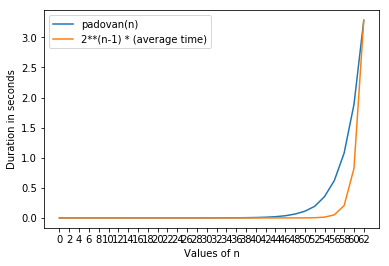

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

times = [] 
data = range(0, 64, 2)

for n in data:
    t = timeit.timeit(stmt="padovan(n)", globals=globals(), number=1)
    times.append(t)

    
plt.plot(data, times, label="padovan(n)")

# Is it really exponential ?
average_by_call = times[-1] / 2**61
plt.plot(data, [(2**(n-1)*average_by_call) for n in data], label="2**(n-1) * (average time)")

plt.xlabel("Values of n")
plt.ylabel("Duration in seconds")
plt.xticks(data)
plt.legend()
plt.show()

### Exercice


Le [jour de dépassement](https://fr.wikipedia.org/wiki/Jour_du_d%C3%A9passement) (Earth Overshoot Day ou EOD) est cette année 2019, le 29 juillet.

Nous savons que les Data Centers du monde entier consomment 10% de la production électrique mondiale.

Si la consommation électrique était proportionnelle à la durée d'exécution d'un programme - ce qui est une assertion loin d'être exacte - en parallélisant à outrance nous pourrions économiser beaucoup de ressources.

Mesurer avec *timeit* le temps de téléchargement en série ou en "parallèle" avec des threads des URL suivantes:

* https://fr.wikipedia.org/wiki/Jour_du_d%C3%A9passement  
* https://www.franceculture.fr/emissions/le-choix-de-la-redaction-13-14/data-centers-les-ogres-energivores-dinternet  
* https://www.connaissancedesenergies.org/sites/default/files/pdf-actualites/guide-pratique-internet-courriels-reduire-impacts.pdf

Dans cet exemple, le programme prendra peut-être trois fois moins de temps pour le téléchargement total, mais 3 processeurs/coeurs fonctionneront au lieu d'un seul, la consommation électrique risque donc d'être 3 fois supérieure sur ce temps réduit.

Vous pouvez utiliser la librairie [requests](https://3.python-requests.org/) pour télécharger simplement les URL:

```python
import requests
r = requests.get('https://3.python-requests.org')
```

Dans l'exercice, commencez par utiliser *http://www.python.org* à la place du fichier PDF, puis utilisez le fichier PDF.


In [10]:
# Example showing how to use a thread
from threading import Thread

def square(x):
    return x**2

# Thread creation
t = Thread(target=square, args=(10,))

# Starting the thread (the function in parallel of main code)
t.start()

# Waiting thread termination
t.join()
print("Done")

Done


In [11]:
import requests
from threading import Thread
import timeit

urls = ['https://fr.wikipedia.org/wiki/Jour_du_d%C3%A9passement'
        , 'https://www.franceculture.fr/emissions/le-choix-de-la-redaction-13-14/data-centers-les-ogres-energivores-dinternet'
        , 'https://www.python.org']  # use python.org first, then try replacing Python.org with PDF file above and see how the gain change

# <your code here>


<button data-toggle="collapse" data-target="#timeit1" class='btn btn-primary'>Solution</button>
<div id="timeit1" class="collapse">

```python

def download_serial(urls):
    for url in urls:
        r = requests.get(url)
        
def download_thread(urls):
    tasks = []
    
    for url in urls:
        t = Thread(target=requests.get, args=(url,))
        t.start()  # starting the function
        # do not join here, else it is like in serial, join is blocking until thread is blocking
        tasks.append(t)  # keeping track of thread
            
    for t in tasks:
        t.join()  # waiting threads to terminate
        
        
r1 = timeit.timeit(stmt="download_serial(urls)", globals=globals(), number=1)
r2 = timeit.timeit(stmt="download_thread(urls)", globals=globals(), number=1)

print("Time using serial download %s seconds" % r1)
print("Time using thread download %s seconds" % r2)
print("Thread versus Serial: x%s" % (r1 / r2))

```


### Jupyter %timeit

Les notebooks jupyter ont aussi un mot clef magique *timeit* basé sur la librairie python


In [12]:
%timeit padovan(5)

288 ns ± 5.58 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Le mot clef accepte aussi des paramètres:

* `-r` : nombre de répétitions/séries de mesures
* `-n` : nombre de mesures par série

Les opérations sont exécutées dans une autre frame, vos variables ne sont pas forcément modifiées après coup

In [13]:
%timeit -r 1 -n 1 padovan(36)

2.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Par exemple, ici, la variable `r` ne contiendra pas la dernière valeur calculée, car dans l'autre frame/bloc, une variable `r` locale est créée.

In [14]:
a = 10
r = 5

%timeit r = a * 2

print( r )

20.1 ns ± 0.308 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
5


Alors qu'ici le code modifie une variable existante, sans qu'il y ait affectation, donc création d'une variable locale à la frame.  Dans ce cas la variable `a` sera modifiée

In [15]:
a = [10]

%timeit -r 1 -n 3 a.append(10)

print( a )

206 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
[10, 10, 10, 10]


In [16]:
%timeit?

Le mot clef existe aussi en version longue pour chronométrer le temps d'exécution d'une cellule.
Voici un exemple avec un algorithme d'intersection très peu efficace.

In [17]:
def intersection(l1, l2):
    inter = []

    for e1 in l1:
        for e2 in l2:
            if e1 == e2:
                inter.append(l1)

    return inter

In [18]:
%%timeit
a = range(2000)
b = range(1000, 3000)
intersection(a, b)
# do not execute print in cell having %%timeit 
# else it may be displayed too too much times, and your kernel may need to be restarted

94.2 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Essayez de multiplier par 10 le nombre d'éléments des listes `l1` et `l2`...

### Jupyter %time

Le mot clef magique `%time` se comporte comme la commande time Unix: Il mesure le temps d'exécution de votre commande et affice 3 temps : système, utilisateur et réel.

Il n'exécute qu'une seule fois la commande.

In [19]:
a = 10
%time a = a+ 1
print(a)
b = []
%time b.append(4)
print(b)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs
11
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs
[4]


Il peut aussi s'appliquer sur une cellule entière:

In [20]:
%%time
r = padovan(36)
print("padovan(36) is", r)

intersection(range(10000), range(5000,15000))
print("Done")

padovan(36) is 17991
Done
CPU times: user 2.24 s, sys: 17 µs, total: 2.24 s
Wall time: 2.25 s


## cProfile



**cProfile** (basée sur l'ancienne librairie lsprof) est elle aussi disponible en standard avec Python.  Cette librairie permet de profiler tout ou partie de votre code et génère des statistiques sur les fonctions, comme leur nombre d'appels ou leur temps d'exécution.  
Elle ne permet cependant pas de mesurer l'usage de la mémoire.

*cProfile* propose un profileur déterministe/événementiel. Mais il reste tout à fait utilisable car la conception de Python fournit déjà toute la mécanique nécessaire pour intercepter tous les appels de fonctions et autres objets. De ce fait l'implémentation de tels profileurs est simple et reste modérément gourmande en ressources.

La librairie possède une fonction *run* qui exécute comme *timeit* le code passé sous forme de chaîne de caractères. Mais dans ce cas, il n'est pas nécessaire de fournir le dictionnaire des objets globaux nécessaires à l'exécution de la fonction.

Le résultat peut être visualisé sous forme de tableau.

In [21]:
import cProfile
cProfile.run("padovan(39)")

         83650 function calls (4 primitive calls) in 0.011 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  83647/1    0.011    0.000    0.011    0.011 <ipython-input-1-6e0191dbf68a>:1(padovan)
        1    0.000    0.000    0.011    0.011 <string>:1(<module>)
        1    0.000    0.000    0.011    0.011 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Les paramètres ont la signification suivante:

* **ncalls** : Le nombre d'appels. Si 2 nombres sont présents cela signifie que la fonction est récursive. Le premier nombre correspond au nombre total d'appels, le second correspond au nombre d'appels de premiers niveau
* **tottime** : La durée totale d'exécution de la fonction, excluant les appels de sous-fonctions
* **percall** : La durée moyenne: Correspond à *ncalls / tottime*
* **cumtime** : Le temps cumulé de la fonction et de toutes ses sous fonctions
* **percall** : Le temps moyen cumulé (appels de premier niveau): Correspond à *cumtime / ncalls*
* **filename:lineno(function)** : comme indiqué: nom de fichier, ligne et nom de fonction


Mais mesurer le temps d'exécution d'un programme en utilisant des chaînes de caractères n'est pas vraiement exploitable pour analyser l'ensemble d'un programme.

Pour cela la librairie permet d'analyser une partie de votre code en instanciant un objet de la classe **Profile** puis en appelant ses méthodes *enable* et *disable*  

L'intégralité du code compris entre ces méthodes sera monitoré:



In [22]:
import time

def countdown(x):
    assert x > 0
    
    while x > 0:
        x -= 1

def cube(x):
    return x ** 3

pr = cProfile.Profile()  # Create the profiler
pr.enable()  # Activate the profiler

padovan(20)  # is profiled
for x in range(1000, 100000, 1000):
    countdown(x)  # is profiled

    
a = range(2000)
b = range(1000, 3000)

intersection(a, b)
    
pr.disable()  # Deactivate the profiler

cube(10)  # is not profiled


1000

La méthode *print_stats* permet quant-à elle d'afficher les statistiques. Il est aussi possible de les sauvegarder dans un fichier avec *dump_stats*

In [23]:
pr.print_stats(sort='cumulative')

         1554 function calls (1156 primitive calls) in 0.259 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.259    0.043 interactiveshell.py:3230(run_code)
        6    0.000    0.000    0.259    0.043 {built-in method builtins.exec}
        1    0.000    0.000    0.156    0.156 <ipython-input-22-eaacf0476223>:16(<module>)
       99    0.156    0.002    0.156    0.002 <ipython-input-22-eaacf0476223>:3(countdown)
        1    0.000    0.000    0.103    0.103 <ipython-input-22-eaacf0476223>:23(<module>)
        1    0.103    0.103    0.103    0.103 <ipython-input-17-a73c801d2e85>:1(intersection)
        6    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
        6    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000    0.000    0.000 <ipython-input-22-eaacf0476223>:15(<module>)
    399/1    0.000    0.000    0.000    0.000 <ipython-inp

Enfin, la classe **[Stats](https://docs.python.org/3/library/profile.html#module-pstats)** permet de personnaliser l'affichage et le calcul des statistiques:

In [24]:
import cProfile, pstats, io

pr = cProfile.Profile()
pr.enable()

# ... doing nice stuff ...
padovan(20)
countdown(10**6)

pr.disable()

s = io.StringIO()

ps = pstats.Stats(pr, stream=s)
ps.strip_dirs()  # remove full path name to file/function
ps.sort_stats('cumtime')  #sort by cumulative time descending
ps.print_stats()

print(s.getvalue())

         428 function calls (30 primitive calls) in 0.032 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.032    0.011 interactiveshell.py:3230(run_code)
        3    0.000    0.000    0.032    0.011 {built-in method builtins.exec}
        1    0.000    0.000    0.032    0.032 <ipython-input-24-550398112cfe>:8(<module>)
        1    0.032    0.032    0.032    0.032 <ipython-input-22-eaacf0476223>:3(countdown)
        1    0.000    0.000    0.000    0.000 <ipython-input-24-550398112cfe>:7(<module>)
    399/1    0.000    0.000    0.000    0.000 <ipython-input-1-6e0191dbf68a>:1(padovan)
        3    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
        3    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        3    0.000    0.000    0.000    0.000 hooks.py:142(__call__)
        1    0.000    0.000    0.000    0.000 <ipython-input-24-550398112cfe>:10(<module>)


### Jupyter prun et lprun

Jupyter propose 2 autres mots clefs magiques permettant de profiler votre code:

* **prun**: Semblable à `%run -p`, cette commande exécute le code en activant le profiler cProfile
* **lprun**: Mesure le temps d'exécution de chaque ligne de code

In [25]:
%prun?

In [26]:
%prun -s calls intersection(range(1000,2000), range(2000, 3000))

In [27]:
ps = %prun -r -s calls padovan(5)
ps.strip_dirs()  # remove full path name to file/function
ps.sort_stats('cumtime')  #sort by cumulative time descending
ps.print_stats()

          8 function calls (4 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
      5/1    0.000    0.000    0.000    0.000 <ipython-input-1-6e0191dbf68a>:1(padovan)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Le mot clef magique `%lprun` n'est pas fourni en standard. C'est un plugin de la librairie [line profiler](https://github.com/rkern/line_profiler)

Il convient d'installer la librairie puis de charger l'extension dans Jupyter

```bash
bash ou C:> pip install line_profiler
```

Ensuite il reste à charger l'extension dans Jupyter:

`%load_ext line_profiler`

In [28]:
%load_ext line_profiler

In [29]:
%lprun?

Il convient d'indiquer quelles sont les fonctions que l'on souhaite analyser dans la commande saisie...  
Ce qui peut paraître déroutant quand il n'y en a qu'une, mais cette option permet de ne profiler que des sous fonctions

In [30]:
%lprun -f intersection intersection(range(1000), range(500,1500))

```
Timer unit: 1e-06 s

Total time: 0.423649 s
File: <ipython-input-19-a73c801d2e85>
Function: intersection at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def intersection(l1, l2):
     2         1          3.0      3.0      0.0      inter = []
     3                                           
     4      1001        199.0      0.2      0.0      for e1 in l1:
     5   1001000     209590.0      0.2     49.5          for e2 in l2:
     6   1000000     213710.0      0.2     50.4              if e1 == e2:
     7       500        146.0      0.3      0.0                  inter.append(l1)
     8                                           
     9         1          1.0      1.0      0.0      return inter
```

Nous commençons à entrevoir la cause des temps relativement élevés de la fonction *intersection* : le test *if* est exécuté 1 million de fois dans cet exemple.

## Définir votre propre profiler

Le module **sys** possède une chouette fonction [*setprofile*](https://docs.python.org/3/library/sys.html#sys.setprofile) qui vous permet de définir une fonction qui sera automatiquement appelée dès que certains évènements se produiront, comme:

* **call** : L'exécution d'une fonction
* **return** : Le retour d'une fonction
* autres...

La fonction d'analyse de code recevra 3 paramètres:

* **frame** : La frame qui va être exécutée
* **event** : le nom de l'évènement, cf ci-dessus
* **arg** : dépend du type de l'évènement

Voici un petit exemple qui ne sera pas exécuté au travers de jupyter car ce dernier génère beaucoup trop d'appels de fonctions lorsqu'il exécute une cellule et cela va perturber la trace attendue:

In [31]:
%%file my_profiler_example.py
# Exemple 
import sys
old_profiler = sys.getprofile()

def my_profiler(frame, event, arg):
    print(f"frame={frame}, event={event}, arg={type(arg)}")
    
    
def square(x):
    return x ** 2

a = list(range(10))
b = list(range(5,15))

# Setting the profiler
sys.setprofile(my_profiler)

square(10)

# Restoring the previous profiler
sys.setprofile(old_profiler)

Writing my_profiler_example.py


In [32]:
!python my_profiler_example.py

frame=<frame at 0x55e802bf7688, file 'my_profiler_example.py', line 9, code square>, event=call, arg=<class 'NoneType'>
frame=<frame at 0x55e802bf7688, file 'my_profiler_example.py', line 10, code square>, event=return, arg=<class 'int'>
frame=<frame at 0x7eff08e829f8, file 'my_profiler_example.py', line 21, code <module>>, event=c_call, arg=<class 'builtin_function_or_method'>


Notre fonction de supervision est appelée 3 fois:

* Au démarrage de square
* Au moment du return de square
* Au début de *sys.setprofile*

Grâce à cette fonction et aux modules d'instrospection de Python, il devient possible de créer ses propres sondes de monitoring de code.

## Exercice relativement difficile
En vous inpirant de la seconde version du code générant le graphe de la suite de Padovan, créer une fonction d'analyse générique qui crée le graphe d'appel des fonctions exécutées entre les 2 instructions *sys.setprofile* ci-dessus.

Il vous sera beaucoup plus facile de définir cette fonction d'analyse comme une méthode de classe, ce qui permettra de manipuler le graphe et les autres paramètres dont vous pourriez avoir besoin comme attributs des instances de la classe.

*Nec plus ultra*: Implémenter les méthodes spéciales de python `__enter__` et `__exit__` qui permettront d'utiliser votre profiler de cette manière:

```python
def square(x):
    return x ** 2

def pado(n):
    return 1 if n <= 2 else pado(n-3) + pado(n-2)

with GraphMe() as gfx:
    pado(6)
    pado(4)
    square(3)
    
gfx.show()
```

![Graph me 3](graphme_3.svg)


Si vous ne connaissez pas les context manager, introduits par la [PEP343](https://www.python.org/dev/peps/pep-0343/), voici une présentation de leur fonctionnement:

Quand vous écrivez:

```python
    with MyObject() as var:
        actions()
```

Python exécute quelque chose qui ressemble à:
```python
    try:
        var = MyObject().__enter__()
        actions()
    finally:
        var.__exit__()
```

Ce qui permet de réaliser de belles choses comme cet exemple [très inspiré d'une autre version trouvée sur stackoverflow](https://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call):


In [33]:
import sys
from io import StringIO

class CaptureOutput:

    def __init__(self):
        self.old_stdout = None
        self.new_stdout = None

    def __enter__(self):
        # Replacing sys.stdout with a file in memory
        self.old_stdout = sys.stdout
        self.new_stdout = StringIO()
        sys.stdout = self.new_stdout

        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        # restoring previous sys.stdout
        sys.stdout = self.old_stdout

    def get(self):
        return self.new_stdout.getvalue()


print("Starting...")

with CaptureOutput() as co:
    print("One")
    print("Two")
    print("Three")

print("Ending...")

print("Captured text is:")
print(co.get())

Starting...
Ending...
Captured text is:
One
Two
Three



<button data-toggle="collapse" data-target="#my_profiler1" class='btn btn-primary'>Solution</button>
<div id="my_profiler1" class="collapse">

```python

"""
GraphMe class is a context manager allowing to generate the call graph of functions
It is a very basic implementation used to demonstrate Python/inspection potential

    from graphme import GraphMe

    def fibo(n):
        return n if n <= 1 else fibo(n-1) + fibo(n-2)

    with GraphMe() as gfx:
        fibo(7)

    gfx.show()
    
"""

import sys
import traceback
from graphviz import Digraph
import inspect

class GraphMe:
    """
    GrapĥMe context manager

    When writing:

    with MyObject() as var:
        actions()

    Python executes something like:

    try:
        var = MyObject().__enter__()
        actions()
    finally:
        var.__exit__()

    This is called context Manager, see PEP343 for more details
    https://www.python.org/dev/peps/pep-0343/
    """

    def __init__(self, filename='graphme', format='svg'):
        self.old_profile = None  # Keep trace of previous profiler if any
        self.graph = None  # graphviz object
        self.call_number = 0  # number of functions called
        self.frame_ids = {}  # keep trace of functions ids to manage unique identifiers and parent link
        self.filename = filename
        self.format = format

    def __enter__(self):

        self.old_profile = sys.getprofile()  # Keep profiler to restore it, if any already set

        # Build the graph
        self.graph = Digraph(filename=self.filename, format=self.format)

        # Reset values
        self.call_number = 0
        self.frame_ids = {}

        # Set caller function used to build graph call
        sys.setprofile(self.caller)

        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.setprofile(self.old_profile)


    def caller(self, frame, event, arg):

        # Only worry about creating graph call for functions
        if event != 'call':
            return

        # The call number is used to help identifying functions
        self.call_number += 1

        # We cannot use frame ids to identify uniquely functions calls
        # Because when a function terminates, its frame id may be reused for new functions
        # generating wrong graph reference, so we use a custom id

        # If id already exists, this is a reused one, we can overwrite it
        key = id(frame)
        self.frame_ids[key] = str(self.call_number)

        # Build frame id and parent frame id
        frame_id = self.frame_ids[key]
        parent_frame = frame.f_back
        p_key = id(parent_frame)

        # If not found, it has not been called inside the with statement, it is the __enter__ statement
        if p_key not in self.frame_ids:
            self.frame_ids[p_key] = None

        parent_frame_id = self.frame_ids[p_key]

        # Parent and current traceback frame information: they contain the functions names
        tb_parent_frame, tb_frame = traceback.extract_stack(frame, limit=2)

        attrs = ", ".join([ "%s=%s" % (k, v if type(v) in (int, float, str, bool) else '...') for k, v in frame.f_locals.items()])

        # Do not graph __exit__
        if self not in frame.f_locals.values():
            self.graph.node(frame_id, "%s(%s)" % (tb_frame.name, attrs))

        # Do not add link to parent if not created in the with statement
        if parent_frame_id is not None:
            self.graph.edge(parent_frame_id, frame_id)


    def show(self):
        self.graph.view()
```


In [34]:
from graphme import GraphMe

def square(x):
    return x ** 3

def pado(n):
    return 1 if n <= 2 else pado(n-3) + pado(n-2)

with GraphMe() as gfx:
    pado(6)
    pado(4)
    square(3)

gfx.show()

Maintenant que nous possèdons une jolie classe, amusons-nous un peu...

In [35]:
def factorial(n):
    return 1 if n <= 1 else n * factorial(n - 1)

with GraphMe() as gfx:
    factorial(3)

gfx.show()

![Factorial](graphme_factorial3.svg)

In [36]:
class ExpressionParenthesee:
    
    def __init__(self, texte):
        self.texte = texte
        self.curseur = 0
        
    def expression(self):
        """Retourne True si l'expression est valide, sinon False"""
        r = self.parenthese_ouvrante() 
        r = r and self.espaces() and self.operande()
        r = r and self.espaces() and self.operateur() 
        r = r and self.espaces() and self.operande()
        r = r and self.parenthese_fermante()
        
        return r
    
    def courant(self):
        """Retourne le caractère courant"""
        return self.texte[self.curseur]
    
    def avance(self):
        self.curseur += 1
    
    def parenthese_ouvrante(self):
        if self.courant() == '(':
            self.avance()
            return True
        else:
            return False
        
    def espaces(self):
        """Toujours vrai:  ou plusieurs espaces"""
        while self.courant() in ('\t', ' '):
            self.avance()
        return True
        
    
    def operande(self):
        return self.nombre() or self.expression()
        
    def operateur(self):
        
        if self.courant() in "+-*/":
            self.avance()
            return True
        return False
    
    def nombre(self):
        
        if self.courant() not in "0123456789":
            return False
        
        while self.courant() in "0123456789":
            self.avance()
            
        return True
  
    def parenthese_fermante(self):
        if self.courant() == ')':
            self.avance()
            return True
        else:
            return False
        
    def is_valid(self):
        try:
            r = self.expression()

            if self.curseur != len(self.texte):
                # Le début est valide, mais il y a du texte après
                return False
        except IndexError:
            return False
        
        return r
    

In [37]:
e = ExpressionParenthesee("(5 + (4*3))")
with GraphMe(filename="expression") as gfx:
    e.is_valid()
    
gfx.show()
    

![expression](expr.svg)

Cela devient vite illisible...

## Pycallgraph2

Vous pouvez être très content de vous si vous avez réussi le "petit" exercice précédent...

Après cela vous pouvez vous demander : *Mais n'est-il pas possible de faire plus simple ?*  Il n'y a-t-il pas des librairies déjà toutes prêtes pour cela ?

La réponse est oui. PyCallGraph est une librairie permettant de réaliser automatiquement ce type de graphiques:


```bash
bash$ pip install pycallgraph2

```
    

In [38]:
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput

def padovan(n):
    return 1 if n <= 2 else pado(n-3) + pado(n-2)

gfx = GraphvizOutput()
gfx.output_file = 'pycallgraph_padovan.png'

with PyCallGraph(output=gfx):
    padovan(6)

![Graphe](pycallgraph_padovan.png)

In [39]:
gfx = GraphvizOutput()
gfx.output_file = 'pycallgraph_expr.png'

e = ExpressionParenthesee("(5 + (4*3))")

with PyCallGraph(output=gfx):
    e.is_valid()
    

![Graphe](pycallgraph_expr.png)

## KCachegrind et pyprof2calltree

[KCachegrind](https://kcachegrind.github.io) est un outil de la suite KDE permettant de visualiser des données de profilage issues de différents formats.

![KCachegrind](https://kcachegrind.github.io/images/KcgShot3.gif)

[pyprof2calltree](https://github.com/pwaller/pyprof2calltree#readme) est une librairie Python qui génère des statistiques de types pStat, qu'il est ensuite possible d'afficher avec *KCachegrind*


Il convient d'abord d'installer ces logiciels:

```bash
bash$ sudo apt install kcachegrind

bash$ pip install pyprof2calltree
```

Ensuite vous lancez le profiling de votre programme avec *pyprof2calltree* et vous consultez les statistiques générées avec *kcachegrind*

Reprenons l'exemple avec l'analyseur d'expressions bien parenthèsées utilisé lors de l'exercice *GraphMe*. Il possède un sympathique graphe d'exécution qui sera plus démonstratif que les fonctions padovan ou intersection précédemment manipulées.

Sous Windows vous devriez pouvoir installer [qcachegrind](https://sourceforge.net/projects/qcachegrindwin/) à la place de *Kcachegrind*

In [40]:
from cProfile import Profile
from pyprof2calltree import convert, visualize

pr = Profile()
pr.enable()

e = ExpressionParenthesee("(5 + (4*3))")
print(e.is_valid())

pr.disable()


True


Nous pouvons maintenant générer les statistiques *pStats* pour les afficher avec *kcachegrind*

In [41]:
stats = pr.getstats()
visualize(stats) 

![Image](kcachegrind_expression.png)

* La liste de gauche vous permet de visualiser la liste des fonctions appelées et leur temps d'exécution
* Les onglets en haut à droite vous permettent de visualiser la carte des fonctions appellées, avec leur imbrication et temps d'utilisation
* Les onglets en bas permettent de visualiser d'autres éléments, notamment le graphe des appels pour la fonction sélectionnée.

## Analyse mémoire

Le module sys de Python propose une fonction *getsizeof* qui retourne l'occupation mémoire d'une variable:

In [42]:
import sys

print(sys.getsizeof(0))  # size is provided in bytes
print(sys.getsizeof(2**800))
print(sys.getsizeof([]))
print(sys.getsizeof([0] * 10**6))  # a list containing 1 milion of zeroes

24
132
64
8000064


In [43]:
def my_range(start, stop, step=1):
    """
    Reproduce a simple version of Python 2 *range* function
    
    Examples:
    
    >>> my_range(10, 20, 2)
    [10, 12, 14, 16, 18]
    
    >>> my_range(20, 10, -2)
    [20, 18, 16, 14, 12]
    
    >>> my_range(10, 20, -1)
    []
    """
    result = []
    
    while start * step < stop * step:
        result.append(start)
        start += step
        
    return result

a = my_range(0, 10**6)
print(sys.getsizeof(a))

8697464


Pour aller un peu plus loin, la librairie [Memory profiler](https://pypi.org/project/memory-profiler/) permet de calculer l'occupation mémoire de chaque ligne de code des fonctions de votre programme, un peu comme *line profiler*.

```bash
bash ou C:> pip install memory_profiler
Ou
bash ou C:> conda install memory_profiler
```

In [44]:
%%file my_range_memory.py

from memory_profiler import profile

@profile(precision=4)
def my_range(start, stop, step=1):
    """
    Reproduce a simple version of Python 2 *range* function
    
    Examples:
    
    >>> my_range(10, 20, 2)
    [10, 12, 14, 16, 18]
    
    >>> my_range(20, 10, -2)
    [20, 18, 16, 14, 12]
    
    >>> my_range(10, 20, -1)
    []
    """
    result = []
    
    while start * step < stop * step:
        result.append(start)
        start += step
        
    return result


if __name__ == "__main__":
    my_range(0, 10**6)

Writing my_range_memory.py


In [45]:
!python my_range_memory.py

Filename: my_range_memory.py

Line #    Mem usage    Increment   Line Contents
     4  36.9414 MiB  36.9414 MiB   @profile(precision=4)
     5                             def my_range(start, stop, step=1):
     6                                 """
     7                                 Reproduce a simple version of Python 2 *range* function
     8                                 
     9                                 Examples:
    10                                 
    11                                 >>> my_range(10, 20, 2)
    12                                 [10, 12, 14, 16, 18]
    13                                 
    14                                 >>> my_range(20, 10, -2)
    15                                 [20, 18, 16, 14, 12]
    16                                 
    17                                 >>> my_range(10, 20, -1)
    18                                 []
    19                                 """
    20  36.9414 MiB   0.0000 MiB       result = []


Ici la démonstration n'est pas très concluante car la ligne append est répétée et l'incrément correspond à celui de la dernière exécution, mais on observe tout de même que la mémoire a doublé entre le début et la fin de la fonction.

Ce sera plus démonstratif avec cet autre exemple



In [46]:
%%file my_range_memory.py

from memory_profiler import profile

def my_range(start, stop, step=1):
    """
    Reproduce a simple version of Python 2 *range* function
    
    Examples:
    
    >>> my_range(10, 20, 2)
    [10, 12, 14, 16, 18]
    
    >>> my_range(20, 10, -2)
    [20, 18, 16, 14, 12]
    
    >>> my_range(10, 20, -1)
    []
    """
    result = []
    
    while start * step < stop * step:
        result.append(start)
        start += step
        
    return result

@profile
def memtest():
    a = my_range(0, 10**6)
    b = my_range(0, 10**6)

if __name__ == "__main__":
   memtest()

Overwriting my_range_memory.py


In [47]:
!python my_range_memory.py

Filename: my_range_memory.py

Line #    Mem usage    Increment   Line Contents
    27     36.8 MiB     36.8 MiB   @profile
    28                             def memtest():
    29     75.8 MiB     39.0 MiB       a = my_range(0, 10**6)
    30    114.4 MiB     38.6 MiB       b = my_range(0, 10**6)




Il est intéressant de voir que la mémoire a augmenté de 39Mib lors de la création de la variable `a`, alors que la taille de `my_range` pour le premier million d'entiers est de 8mo environ, comme vu précédemment. En fait, la fonction append alloue plus qu'un élément à chaque appel: si la liste n'a plus de place, le tableau est incrémenté de 10 éléments la première fois que la limite de stockage est atteinte, puis 100, puis 1000 etc... 



La librairie permet aussi de visualiser l'encombrement mémoire de votre programme au fil du temps, en permettant d'inclure les différents sous-process si besoin.

In [48]:
!mprof run my_range_memory.py

mprof: Sampling memory every 0.1s
running as a Python program...
Filename: my_range_memory.py

Line #    Mem usage    Increment   Line Contents
    27     37.0 MiB     37.0 MiB   @profile
    28                             def memtest():
    29     75.7 MiB     38.7 MiB       a = my_range(0, 10**6)
    30    115.0 MiB     39.3 MiB       b = my_range(0, 10**6)




```bash
bash ou c:> mprof plot
```

La librairie matplotlib doit être installée pour cela.

![mprof plot](mprof_plot.png)

### Jupyter memit et mprun

La librairie *memory_profiler* propose aussi des mots clefs magiques pour Jupyter:

* **memit** : Mesure l'occupation mémoire d'une instruction ou cellule
* **mprun** : Mesure l'encombrement mémoire d'un fonction ligne par ligne

In [49]:
%load_ext memory_profiler

In [50]:
%memit my_range(0, 10**6)
%memit range(0, 10**6)

peak memory: 167.82 MiB, increment: 35.37 MiB
peak memory: 140.32 MiB, increment: 0.00 MiB


In [51]:
from my_range_memory import my_range
%mprun -f my_range my_range(0, 10**4)

## Optimisations

Maintenant que nous avons découvert différents outils de profiling, nous allons étudier quelques optimisations possibles et classiques en Python

![super hero](superhero.jpg "Pixabay https://pixabay.com/illustrations/superhero-girl-speed-runner-534120/")

### Padovan

Notre implémentation de la suite de padovan est particulièrement lente:

In [52]:
def padovan(n):
    return 1 if n <= 2 else padovan(n - 3) + padovan(n - 2)

**timeit** nous montre que la fonction est lente: près de 2 secondes pour padovan de 60

In [53]:
%timeit -n 1 -r 1 padovan(60)

1.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


**cProfile** nous permet de comprendre pourquoi : padovan(60) appelle 30 693 571 fois la fonction !

In [54]:
from cProfile import Profile
pr = Profile()
pr.enable()
padovan(60)
pr.disable()
pr.print_stats()

         30693590 function calls (20 primitive calls) in 4.089 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
30693571/1    4.089    0.000    4.089    4.089 <ipython-input-52-427ea08287cb>:1(padovan)
        1    0.000    0.000    4.089    4.089 <ipython-input-54-2143d4ed2f36>:4(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-54-2143d4ed2f36>:5(<module>)
        2    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
        2    0.000    0.000    0.000    0.000 hooks.py:142(__call__)
        2    0.000    0.000    0.000    0.000 hooks.py:207(pre_run_code_hook)
        2    0.000    0.000    0.000    0.000 interactiveshell.py:1258(user_global_ns)
        2    0.000    0.000    4.089    2.045 interactiveshell.py:3230(run_code)
        2    0.000    0.000    0.000    0.000 ipstruct.py:125(__getattr__)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        2    0.

**GraphMe**, **pycalgraph2** ou encore **pyprof2calltree** nous permettent de mieux visualiser les différents appels

In [55]:
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput

gfx = GraphvizOutput()
gfx.output_file = 'pycallgraph_padovan_50.png'

with PyCallGraph(output=gfx):
    padovan(50) # With 60 it is too long to wait for...

![pado 50](pycallgraph_padovan_50.png)

Ici, l'implémentation récursive est élégante mais pas du tout optimisée. Chaque appel en génère 2 autres et ainsi de suite. C'est exponentiel comme nous l'avons déjà vu.

Il y a différentes manières d'optimiser cette fonction :

* Eviter la récursivité avec une version itérative
* Eviter de recalculer les valeurs déjà calculées avec un mécanisme de cache

In [56]:
def padovan(n):
    """
    Python web site has a nice implementation of Fibonacci on its home page
    Here is an adjustment for Padovan
    """
    a, b, c = 1, 1, 1
    
    ind = 0

    while ind != n:
        a, b, c = b, c, a + b
        ind += 1
        
    return a

for n, value in enumerate([1, 1, 1, 2, 2, 3, 4, 5, 7, 9, 12]):
    r = padovan(n)
    assert r == value, f'Bad value for n={n} expected {value} got {r}'
    
%timeit padovan(60)

2.72 µs ± 28 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Mais toutes les fonctions ne peuvent pas se ré-écrire aussi facilement. Dans ce cas, lorsqu'une fonction déterministe demande un long temps de calcul, il est possible de mettre en cache les valeurs déjà calculées pour ne pas les recalculer aux appels suivants si la fonction est rappelée avec les mêmes paramètres.

Nous entendons ici par fonction déterministe une fonction qui retourne toujours la même valeur si on l'appelle avec les mêmes paramètres. 

* Le calcul du nième nombre premier sera une fonction déterministe
* Le calcul de la nième décimale de PI en sera une autre
* En général toutes les fonctions mathématiques du type $y = f(x)$ sont de telles fonctions

Voici une nouvelle version de la suite de Padovan avec cache.

In [57]:
cache_pado = {0 : 1, 1 : 1, 2 : 1}

def padovan(n):
        
    # check if n is a key of cache, if not, compute it and store it in cache
    if n not in cache_pado:
        cache_pado[n] = padovan(n - 3) + padovan(n - 2)
        
    return cache_pado[n]

%timeit -n 1 -r 1 padovan(60)  # First call is a bit longer 
                               # because all 60 first values need to be computed
%timeit padovan(60)  # already in cache, so very fast
print(cache_pado)

17.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
76.6 ns ± 0.937 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
{0: 1, 1: 1, 2: 1, 3: 2, 4: 2, 6: 4, 5: 3, 7: 5, 9: 9, 8: 7, 10: 12, 12: 21, 11: 16, 13: 28, 15: 49, 14: 37, 16: 65, 18: 114, 17: 86, 19: 151, 21: 265, 20: 200, 22: 351, 24: 616, 23: 465, 25: 816, 27: 1432, 26: 1081, 28: 1897, 30: 3329, 29: 2513, 31: 4410, 33: 7739, 32: 5842, 34: 10252, 36: 17991, 35: 13581, 37: 23833, 39: 41824, 38: 31572, 40: 55405, 42: 97229, 41: 73396, 43: 128801, 45: 226030, 44: 170625, 46: 299426, 48: 525456, 47: 396655, 49: 696081, 51: 1221537, 50: 922111, 52: 1618192, 54: 2839729, 53: 2143648, 55: 3761840, 57: 6601569, 56: 4983377, 58: 8745217, 60: 15346786}


Cette implémentation est sympathique mais a l'inconvénient de nécessiter une variable globale. Ce n'est pas très efficace ni élégant. On peut rendre cela un brin plus propre.

In [58]:
def padovan(n):
        
    # check if n is a key of cache, if not, compute it and store it in cache
    if n not in padovan.cache:
        padovan.cache[n] = padovan(n - 3) + padovan(n - 2)
        
    return padovan.cache[n]

padovan.cache = {0 : 1, 1 : 1, 2 : 1}
%timeit -n 1 -r 1 padovan(60)  # First call is a bit longer 
                                 # because all 60 first values need to be computed
%timeit padovan(60)  # already in cache, so very fast

print(padovan.cache)

24.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
104 ns ± 1.73 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
{0: 1, 1: 1, 2: 1, 3: 2, 4: 2, 6: 4, 5: 3, 7: 5, 9: 9, 8: 7, 10: 12, 12: 21, 11: 16, 13: 28, 15: 49, 14: 37, 16: 65, 18: 114, 17: 86, 19: 151, 21: 265, 20: 200, 22: 351, 24: 616, 23: 465, 25: 816, 27: 1432, 26: 1081, 28: 1897, 30: 3329, 29: 2513, 31: 4410, 33: 7739, 32: 5842, 34: 10252, 36: 17991, 35: 13581, 37: 23833, 39: 41824, 38: 31572, 40: 55405, 42: 97229, 41: 73396, 43: 128801, 45: 226030, 44: 170625, 46: 299426, 48: 525456, 47: 396655, 49: 696081, 51: 1221537, 50: 922111, 52: 1618192, 54: 2839729, 53: 2143648, 55: 3761840, 57: 6601569, 56: 4983377, 58: 8745217, 60: 15346786}


Et enfin, on peut le rendre générique avec un décorateur 

In [59]:
from functools import wraps
from time import sleep

def cache(func_to_patch):
    
    cache = {}  # local variable caught using closure
                # We also could keep the cache as an attribute of patch, just as before
    def patch(*args):
        """patch will replace func_to_patch but keep reference to original func_to_patch"""
        if args not in cache:
            cache[args] = func_to_patch(*args)  # call original function
            
        return cache[args]
    
    return patch


@cache
def padovan(n):
    """
    when writing @something before a function name, python creates the function, then executes

    function = something(function)
    
    here, this means
    
    padovan = cache(padovan)
    
    So padovan is replaced by the result of cache: the patch function
    
    """
    return 1 if n <= 2 else padovan(n - 3) + padovan(n - 2)
    
%timeit -n 1 -r 1 padovan(60)
%timeit padovan(60)

@cache
def cube(n):
    sleep(1)
    return n ** 3

%timeit -n 1 -r 1 cube(60)
%timeit cube(60)


62.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
118 ns ± 2.04 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
116 ns ± 0.812 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Un décorateur peut aussi s'écrire en version objet.

In [60]:
class Cache:
    
    def __init__(self, func_to_patch):
        self.func = func_to_patch
        self.cache = {}
        
    def __call__(self, *args):
        """
        When you write:
        a = Cache(func)
        a(x, y, z) # here, python executes Cache.__call__(a, x, y, z)
        """
        if args not in self.cache:
            self.cache[args] = self.func(*args)
            
        return self.cache[args]
        
@Cache
def padovan(n):
    """
    Here Python executes
    
    padovan = Cache(padovan)
    
    So, padovan is an instance of Cache
    and padovan.func = <old padovan, this code below>
    """
    return 1 if n <= 2 else padovan(n - 3) + padovan(n - 2)
    
    
%timeit -n 1 -r 1 padovan(60)  # Cache.__call__(padovan, 60)
%timeit padovan(60)
padovan.cache

33.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
176 ns ± 1.48 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


{(0,): 1,
 (1,): 1,
 (3,): 2,
 (2,): 1,
 (4,): 2,
 (6,): 4,
 (5,): 3,
 (7,): 5,
 (9,): 9,
 (8,): 7,
 (10,): 12,
 (12,): 21,
 (11,): 16,
 (13,): 28,
 (15,): 49,
 (14,): 37,
 (16,): 65,
 (18,): 114,
 (17,): 86,
 (19,): 151,
 (21,): 265,
 (20,): 200,
 (22,): 351,
 (24,): 616,
 (23,): 465,
 (25,): 816,
 (27,): 1432,
 (26,): 1081,
 (28,): 1897,
 (30,): 3329,
 (29,): 2513,
 (31,): 4410,
 (33,): 7739,
 (32,): 5842,
 (34,): 10252,
 (36,): 17991,
 (35,): 13581,
 (37,): 23833,
 (39,): 41824,
 (38,): 31572,
 (40,): 55405,
 (42,): 97229,
 (41,): 73396,
 (43,): 128801,
 (45,): 226030,
 (44,): 170625,
 (46,): 299426,
 (48,): 525456,
 (47,): 396655,
 (49,): 696081,
 (51,): 1221537,
 (50,): 922111,
 (52,): 1618192,
 (54,): 2839729,
 (53,): 2143648,
 (55,): 3761840,
 (57,): 6601569,
 (56,): 4983377,
 (58,): 8745217,
 (60,): 15346786}

Finalement, Python propose déjà un tel décorateur dans le module functools

In [61]:
from functools import lru_cache

In [62]:
@lru_cache(maxsize=None)
def padovan(n):
    return 1 if n <= 2 else padovan(n - 3) + padovan(n - 2)
    
    
%timeit -n 1 -r 1 padovan(60)  # Cache.__call__(padovan, 60)
%timeit padovan(60)
padovan.cache_info()

13.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
42.6 ns ± 0.775 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


CacheInfo(hits=81111166, misses=60, maxsize=None, currsize=60)

### Intersection

> Le plus important dans un programme ce n'est pas l'algorithme, mais la structure de données

*Peut-être [Donald Knuth](https://fr.wikipedia.org/wiki/Donald_Knuth)*, mais je n'ai pas réussi à retrouver la citation exacte

In [63]:
def intersection(l1, l2):
    
    result = []
    
    for e1 in l1:
        for e2 in l2:
            if e1 == e2:
                result.append(e1)
                
    return result


%timeit intersection(range(1, 2000), range(1000, 3000))
%timeit -n 1 -r 1 intersection(range(1, 20000), range(10000, 30000))

87.8 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


*timeit* nous montre que lorsque l'on augmente par 10 le nombre d'éléments, le temps d'exécution passe de 0.093 sec à 9.29 sec.  
Il est multiplié par 100 !

In [64]:
def intersection(l1, l2):
    
    result = []
    
    for e1 in l1:  # If M elements in l1
        for e2 in l2:  # If N elements in l2
            if e1 == e2:  # This test is executed M*N times
                          # If M=N, complexity is N*N = N**2 opérations 
                result.append(e1)
                
    return result

En effet, s'il y a `M` éléments dans l1 et `N` dans l2 le test *if* est exécuté `M*N` fois.  Si `M` est égal à `N`, le nombre d'opérations pour réaliser l'intersection est égal à `N*N` soit `N**2`.  

On dit que la complexité de l'algorithme est de l'ordre de `N**2`, ce qui se note $O(N^2)$

In [65]:
%lprun -f intersection intersection(range(1, 2001), range(1000, 3000))

```
Timer unit: 1e-06 s

Total time: 1.63322 s
File: <ipython-input-1-2de2675686e0>
Function: intersection at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def intersection(l1, l2):
     2                                               
     3         1          1.0      1.0      0.0      result = []
     4                                               
     5      2001        375.0      0.2      0.0      for e1 in l1:
     6   4002000     805409.0      0.2     49.3          for e2 in l2:
     7   4000000     827190.0      0.2     50.6              if e1 == e2:
     8      1001        248.0      0.2      0.0                  result.append(e1)
     9                                                           
    10         1          0.0      0.0      0.0      return result
```

Ici, l'on observe bien que le test *if* est exécuté `2000 * 2000` fois

Il existe différentes manières d'optimiser cet algorithme.   
Commençons par le plus simple: il est inutile de continuer de chercher `e1` dans `l2` s'il a déjà été trouvé. Un *break* après le *append* nous fera gagner quelques itérations...

In [66]:
def intersection(l1, l2):
    
    result = []
    
    for e1 in l1:  
        for e2 in l2:  
            if e1 == e2:  
                result.append(e1)
                break
                
    return result

%timeit intersection(range(1, 2000), range(1000, 3000))
%timeit -n 1 -r 1 intersection(range(1, 20000), range(10000, 30000))

54.6 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


L'optimisation n'est pas encore fabuleuse mais le temps a diminué de près de 50%. La complexité reste toujours de l'ordre du carré.  


Nous pouvons encore gagner un peu de temps:  Python dispose de son propre opérateur *in* qui permet de vérifier si un élément existe dans une liste. Ceci nous permet d'économiser une boucle.  

In [67]:
def intersection(l1, l2):
    
    result = []
    
    for e1 in l1: # if M éléments in l1
        if e1 in l2: # M tests are executed
                     # But does complexity still the same... ?
            result.append(e1)
                
    return result

%timeit intersection(list(range(1, 2000)), list(range(1000, 3000)))
%timeit -n 1 -r 1 intersection(list(range(1, 20000)), list(range(10000, 30000)))

17.5 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Nous venons de réduire le temps d'un facteur 3, mais la mesure du temps d'exécution montre que la complexité reste de l'ordre du carré du nombre d'éléments: Si le nombre d'éléments augmente d'un facteur `x10`, la durée augmente d'un facteur `x100`

En fait l'opérateur *in* masque une boucle imbriquée, il compare `e1` à tous les éléments de `l2` et s'arrête lorsqu'il trouve une correspondance ou s'il arrive à la fin de `l2`.  Cela reste plus rapide car cet opérateur est implémenté en langage `C`  et donc plus performant qu'une boucle Python.  

Cette complexité est confirmée par ce [tableau des complexités des instructions du wiki Python](https://wiki.python.org/moin/TimeComplexity)  

L'opérateur `in` a une complexité de $O(N)$, autrement dit, si la liste possède `N` éléments, `N` opérations seront exécutées.

Ce tableau montre aussi que les types *set* et *dict* possèdent un opérateur *in* ayant une complexité d'ordre 1, autrement dit, si l'objet set/dict possède N éléments, l'opérateur *in* ne demandera qu'une instruction !

Si vous avez été observateurs, vous aurez remarqué que le code a été quelque peu transformé dans l'exemple précédent: la fonction intersection a reçu des listes et non des objets *range*

In [68]:
%timeit intersection(range(1, 2000), range(1000, 3000))
%timeit -n 1 -r 1 intersection(range(1, 20000), range(10000, 30000))

134 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


En effet, en Python 2, la fonction range retourne une liste, mais en Python 3 cette fonction est un type à part entière qui implémente son propre opérateur *in* qui calcule si les éléments sont présents ou non. De ce fait il est extrêmement rapide et sa complexité est d'ordre $O(1)$

Essayons avec cette première implémentation:

In [69]:
def intersection(l1, l2):
    
    result = []
    # We create a dictionary having l1 items as keys
    d1 = {}
    for e1 in l1:
        d1[e1] = None  # We do not care about the values, just keys are important here

    # Can also be written as
    # d1 = { e1 : None for e1 in l1 }
    # d1 = dict.fromkeys(l1)

    # Now we check if items of l2 are keys of d1
    for e2 in l2:
        if e2 in d1:
            result.append(e2)
            
    return result

%timeit intersection(range(1, 2000), range(1000, 3000))
%timeit -n 1 -r 1 intersection(range(1, 20000), range(10000, 30000))

155 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.83 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Nous observons ici 2 choses:

* La durée d'exécution est nettement plus courte
* La complexité semble linéaire : si le nombre d'éléments est multiplié par 10, le temps l'est aussi, enfin, à peine

In [70]:
def intersection(l1, l2):
    
    result = []
    # We create a dictionary having l1 items as keys
    d1 = {}
    for e1 in l1:
        d1[e1] = None  # If M items in l1, M affectations are executed

    # Now we check if items of l2 are keys of d1
    for e2 in l2:
        if e2 in d1:  # If N items in l2, N tests are executed
                      # But the *in* operator computes if e2 belongs to d1 keys, it does not compare it
                      # to each key, so this is really fast !
            result.append(e2)
            
    # Finally we've got N+M opérations, if N=M, 2N opérations, complexity is O(2N)
            
    return result

La création du dictionnaire requiert `M` affectations si `l1` possède `M` éléments.  
La recherche de `e2` dans les clefs de `d1` est exécutée `N` fois si `l2` possède `N` éléments.  
Comme la complexité de l'opérateur `in` du dictionnaire est $O(1)$, il n'y a pas de parcours masqué et au final nous avons `M+N` opérations, soit `2N` opérations si M=N.  
La complexité est devenue linéaire grâce à une structure de données performante.  

Pourquoi l'opérateur `in` dans un dictionnaire est aussi efficace ? Parce qu'il utilise une structure de données très adaptée et l'algorithme [Open Adressing](https://en.wikipedia.org/wiki/Open_addressing) pour rechercher ses clefs.  

En quelque mots, un dictionnaire est un tableau indicé, où à un indice donné sont stockés et la clef et sa valeur.  Quand on veut accéder à une clef, une fonction de hachage caclule l'indice de cette clef via l'algorithme précédent.  Si l'indice retourné est inférieur au nombre d'éléments du tableau : la clef existe, sinon c'est une nouvelle clef.  

Si vous êtes curieux, cet excellent article de *Laurent Luce* explique plus en détails [l'implémentation des dictionnaires](https://www.laurentluce.com/posts/python-dictionary-implementation/).

Dans cet exercice nous avons utilisé un dictionnaire ne possédant que des clefs, les valeurs n'ont pas été utilisées.  
Ce type de dictionnaire est appelé un **set** en Python et constitue un type à part entière avec de véritables opérations ensemblistes.  

* Un set ne peut avoir qu'une seule occurrence d'une même valeur
* Un set ne peut contenir que des types non modifiables (non mutable)

Son opérateur d'intersection `&` est implémenté grosso-modo comme dans l'exemple précédent avec le dictionnaire.

In [71]:
def intersection(l1, l2):
    s1 = set(l1)
    s2 = set(l2)
    
    return s1 & s2

%timeit intersection(range(1, 2000), range(1000, 3000))
%timeit -n 1 -r 1 intersection(range(1, 20000), range(10000, 30000))

87.1 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.28 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Cette fois nous explosons tous les records.  

Il y a encore d'autres manières de traiter cet exercice.  
(Voici une solution qui m'a été soufflée par l'un des participants d'une formation Python que j'ai dispensée)  

En supposant que les listes soient triées, on peut diminuer le nombre d'opérations à *au mieux* `max( [ len(l1), len(l2) ] )` opérations et *au pire* `N+M` opérations:

In [72]:
def intersection(l1, l2):
    """Suppose that l1 and l2 are ordered"""
    
    result = []
    
    ind1, ind2 = 0, 0
    len1, len2 = len(l1), len(l2)
    
    while ind1 < len1 and ind2 < len2:
        
        e1 = l1[ind1]
        e2 = l2[ind2]
        
        if e1 == e2:  # match found
            result.append(e1)
            # increment both indices
            ind1 += 1
            ind2 += 1
        elif e1 < e2:
            # e1 is lower than e2, search next element in l1
            ind1 += 1
        else:
            ind2 += 1
            
    return result


%timeit intersection(list(range(1, 2000)), list(range(1000, 3000)))
%timeit -n 1 -r 1 intersection(list(range(1, 20000)), list(range(10000, 30000)))

249 µs ± 5.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.76 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


On peut s'affranchir de la supposition sur le tri en triant les listes en début de fonction.  
Les performances restent très bonnes.

In [73]:
def intersection(l1, l2):
    """l1 and l1 are sorted after the function: dangerous"""
    
    l1.sort()
    l2.sort()    
    
    result = []
    
    ind1, ind2 = 0, 0
    len1, len2 = len(l1), len(l2)
    
    while ind1 < len1 and ind2 < len2:
        
        e1 = l1[ind1]
        e2 = l2[ind2]
        
        if e1 == e2:  # match found
            result.append(e1)
            # increment both indices
            ind1 += 1
            ind2 += 1
        elif e1 < e2:
            # e1 is lower than e2, search next element in l1
            ind1 += 1
        else:
            ind2 += 1
            
    return result

%timeit intersection(list(range(1, 2000)), list(range(1000, 3000)))
%timeit -n 1 -r 1 intersection(list(range(1, 20000)), list(range(10000, 30000)))

261 µs ± 5.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Python propose de nombreux autres [structures de données très intéressantes qui peuvent vous aider à optimiser/simplifier vos algorithmes](https://docs.python.org/3/library/datatypes.html).  

Pour creuser le sujet voici quelques ouvrages :

* Le livre [Problem Solving with Algorithms and Data Structures using Python](https://runestone.academy/runestone/books/published/pythonds/index.html) en license creative commons.  
* Le site PacktPublishing propose aussi plusieurs livre sur le theme [Python Data structures and algorithms](https://subscription.packtpub.com/search?query=python%20data%20structure&released=Available)  



## My range

Nous avons vu que notre fonction *my_range* n'est pas intéressante dans sa version actuelle:  elle retourne une liste d'éléments.  
Si vous voulez l'utiliser pour compter de 1 à 1 million dans une boucle *for*, vous allez allouer 1 million d'entiers :

* Cela demandera de la mémoire
* Cela prend du temps pour l'allocation de cette mémoire


C'est la réflexion que se sont faits les développeurs de Python 3. En Python 2, beaucoup de fonctions qui retournaient de véritables listes, comme *range*, *filter*, *map*, *zip* sont devenues des générateurs/itérateurs ou types à part entière pour contourner ce problème.

In [74]:
!python2 -c "a = range(10); print type(a), a"

<type 'list'> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [75]:
!python3 -c "a = range(10); print(type(a), a)"

<class 'range'> range(0, 10)


La plupart des fonctions qui retournent de grandes listes de données méritent probablement d'être ré-écrites sous forme de générateur.

Un générateur est une fonction qui au lieu de retourner une liste de valeurs, retourne la première valeur au premier appel, puis la seconde au second appel et ainsi de suite.

Pour permettre ce comportement votre fonction ne doit pas retourner de valeur avec le mot clef *return* mais avec un nouveau mot clef **yield** qui retourne une valeur et met la fonction en pause. 

A l'appel suivant, la fonction reprend juste après l'instruction *yield*



Pour transformer une fonction en générateur, il y a 3 étapes à réaliser:

1. Supprimer la création de la liste contenant le résultat, généralement `result = []` 
2. Remplacer `result.append(value)` par `yield value`
3. Finalement, supprimer l'instruction `return result` 

Si nous reprenons la version initiale de *my_range*

In [76]:
def my_range(start, stop, step=1):
    """
    Reproduce a simple version of Python 2 *range* function
    
    Examples:
    
    >>> my_range(10, 20, 2)
    [10, 12, 14, 16, 18]
    
    >>> my_range(20, 10, -2)
    [20, 18, 16, 14, 12]
    
    >>> my_range(10, 20, -1)
    []
    """
    result = []
    
    while start * step < stop * step:
        result.append(start)
        start += step
        
    return result

for a in my_range(5, -1, -1):
    print(a)

5
4
3
2
1
0


Sa version générateur donnera:

In [77]:
def my_range_gen(start, stop, step=1):
    """
    generator version of my_range
    """
    # result = []  # no more requires
    
    while start * step < stop * step:
        # result.append(start)
        yield start
        start += step
        
    # return result  # no more required

for a in my_range_gen(5, -1, -1):
    print(a)

5
4
3
2
1
0


Le résultat est le même, mais l'encombrement mémoire est nettement moindre.

In [78]:
import sys
print(sys.getsizeof(my_range(0, 10**6)), sys.getsizeof(my_range_gen(0, 10**6)))

8697464 120


Pour mieux comprendre comment cela se passe, ajoutons une trace dans la version générateur:

In [79]:
def my_range_gen(start, stop, step=1):
    """
    generator version of my_range
    """
    while start * step < stop * step:
        print("Before yield, start=", start)
        yield start
        print("After yield, start=", start)
        start += step

        
for a in my_range_gen(3, -1, -1):
    print(a)

Before yield, start= 3
3
After yield, start= 3
Before yield, start= 2
2
After yield, start= 2
Before yield, start= 1
1
After yield, start= 1
Before yield, start= 0
0
After yield, start= 0


Au premier appel de la fonction par le *for* la fonction s'exécute et affiche `Before yield, start= 3` puis retourne `3` et se met en pause.  
La boucle *for* reprend la main, affiche la valeur `3` puis rappelle la fonction, qui se réveille et continue juste ou elle s'était arrêtée, c'est à dire après le mot clef *yield* et affiche `After yield, start= 3`  
Et ainsi de suite.

Ce qui peut surprendre c'est que cela fonctionne aussi avec des boucles imbriquées.

In [80]:
def my_range_gen(start, stop, step=1):
    """
    generator version of my_range
    """
    
    while start * step < stop * step:
        yield start
        start += step
        

for a in my_range_gen(3, -1, -1):
    print(a)
    for b in my_range_gen(10, 20, 5):
        print("  ", b)

3
   10
   15
2
   10
   15
1
   10
   15
0
   10
   15


Comment la fonction fait-elle pour ne pas se mélanger les pinceaux entre les appels imbriqués, les valeurs de *start, stop* et les incréments ?

En fait notre première explication de la mécanique des générateurs a été quelque peu simplifiée pour faciliter la compréhension globale.

* Quand une fonction possède le mot clef *yield* Python la transforme
* Lors de son appel elle ne s'exécute pas mais retourne une copie de la fonction originale avec ses paramètres
* Pour la démarrer il faut utiliser la fonction **next**

In [81]:
def my_range_gen(start, stop, step=1):
    """
    generator version of my_range
    """
    print("Running with values", start, stop, step)
    
    while start * step < stop * step:
        print("Before yield, start=", start)
        yield start
        print("After yield, start=", start)
        start += step


Appelons la fonction:

In [82]:
g = my_range_gen(10, 14, 2)

Rien ne s'exécute. Mais une copie de la fonction est retournée dans l'objet *g* qui est ce que l'on appelle un générateur

In [83]:
g

<generator object my_range_gen at 0x7fb71813ade0>

Il convient de démarrer `g` avec la fonction *next*

In [84]:
v = next(g)
print(v)

Running with values 10 14 2
Before yield, start= 10
10


Nous pouvons demander la valeur suivante

In [85]:
v = next(g)
print(v)

After yield, start= 10
Before yield, start= 12
12


Quand il n'y a plus rien à retourner, un nouvel appel à *next* génère une exception **StopIteration**

```python

v = next(g)
print(v)
```

```
After yield, start= 12

---------------------------------------------------------------------------
StopIteration                             Traceback (most recent call last)
<ipython-input-103-142a79cb4c53> in <module>
----> 1 v = next(g)
      2 print(v)

StopIteration: 

```

Dans une boucle *for* ceci est transparent, c'est la boucle qui exécute de manière transparente les appels à *next* et intercepte l'exception *StopIteration*

#### Un générateur c'est bête, un itérateur c'est mieux

Il y aurait beaucoup de choses à dire sur les générateurs. Nous aborderons ici uniquement quelques unes de ses limitations afin de savoir jusqu'où l'on peut aller et comment faire mieux avec les *itérateurs*

In [86]:
def my_range_gen(start, stop, step=1):
    
    while start * step < stop * step:
        yield start
        start += step


Un générateur ne se consomme qu'une fois

In [87]:
r = range(0, 3)
g = my_range_gen(0, 3)

In [88]:
for v in r:
    print(v)
    
for v in r:  # range is clever and allow multiple iterations
    print(v)

0
1
2
0
1
2


In [89]:
for v in g:
    print(v)
    
for v in g:  # already reached the end of the function
    print(v)

0
1
2


Un générateur ne garantit pas un bon usage de *in*

In [90]:
def my_range_gen(start, stop, step=1):
    
    while start * step < stop * step:
        print("start=", start)
        yield start
        start += step

In [91]:
r = range(0, 3)
g = my_range_gen(0, 3)

In [92]:
2 in r, 10 in r, 2 in r, 10 in r

(True, False, True, False)

In [93]:
2 in g, 10 in g, 2 in g, 10 in g

start= 0
start= 1
start= 2


(True, False, False, False)

L'opérateur *in* fonctionne avec un générateur, mais il itère sur les éléments pour trouver les valeurs demandées.  Quand il cherche `10` qu'il ne trouve pas, il consomme toute la liste. Si l'on redemande `2`, il retournera *False* car la liste a été consommée entièrement pour `10` et il ne se consomme qu'une fois...  

Ils ont aussi d'autres limites, comme l'absence des opérateurs `[]` pour lire un élément ou encore de la fonction *len*

Pour contourner ces limites vous pouvez implémenter votre générateur sous forme d'une classe.  

Pour cela 2 méthodes spéciales sont requises:

* `__iter__` qui retourne l'itérateur, en général l'instance elle-même sauf si vous voulez implémenter des itérateurs *à la Java*
* `__next__` qui retourne la valeur suivante et génère *StopIteration* s'il n'y a plus rien à retourner



In [94]:
class MyRange:
    
    def __init__(self, start, stop, step=1):
        self.start = start
        self.stop = stop
        self.step = step
        self.current = start
        
    def __iter__(self):
        return self
    
    def __next__(self):
        
        # keep current value to be returned
        cur = self.current
        
        # raise exception if end is reached
        if cur * self.step >= self.stop * self.step:
            raise StopIteration()
        
        # increment current for next call
        self.current += self.step
        
        return cur
    
for v in MyRange(3, -1, -1):
    print(v)

3
2
1
0


#### Exercice

Modifiez la classe pour que votre générateur implémente correctement l'opérateur *in* et puisse être utilisé de multiples fois.  Pour l'opérateur *in* implémentez la méthode [`__contains__`](https://docs.python.org/3/reference/datamodel.html#object.__contains__)

```python
class MyRange:
    
    # your code here
    pass

    
    
g = MyRange(3, -1, -1)
assert list(g) == [3, 2, 1, 0]
assert list(g) == [3, 2, 1, 0]  # Twice use should not be empty
print("Twice use implemented !")

assert (2 in g, 10 in g, 2 in g) == (True, False, True)
print("in correctly implemented !")
```

<button data-toggle="collapse" data-target="#MyRange" class='btn btn-primary'>Solution</button>
<div id="MyRange" class="collapse">

```python
class MyRange:
    
    def __init__(self, start, stop, step=1):
        self.start = start
        self.stop = stop
        self.step = step
        self.current = start
        
    def __iter__(self):
        return self
    
    def __next__(self):
        
        # keep current value to be returned
        cur = self.current
        
        # raise exception if end is reached
        if cur * self.step >= self.stop * self.step:
            self.current = self.start  # reset current for next iteration
            raise StopIteration()
        
        # increment current for next call
        self.current += self.step
        
        return cur
    
    def __contains__(self, value):
        
        # Check if outside interval
        if value * self.step < self.start * self.step:
            return False

        # Check if outside interval
        if value * self.step >= self.stop * self.step:
            return False
        
        # Value is between start and stop, check if mutiple of step minus start
        return (value - self.start) % self.step == 0
```

Vous pouvez maintenant utiliser la version d'intersection avec une seule boucle *for* et l'opérateur *in* avec votre itérateur: elle sera très efficace puisque votre version de `__contains__` calcule (si bien implémentée) si la valeur demandée existe, plutôt que de la comparer avec tous les éléments de la liste...

```python
def intersection(l1, l2):
    
    result = []
    
    for e1 in l1:
        if e1 in l2:
            result.append(e1)
            
    return result

%timeit intersection(MyRange(1, 2000), MyRange(1000, 3000))
%timeit intersection(MyRange(1, 20000), MyRange(10000, 30000))

```

```
935 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.52 ms ± 46.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

Sa complexité sera linéaire. 

Et évidemment, *intersection* mérite d'être ré-écrite avec un générateur !

## Parallélisation

Une fois que votre code a été optimisé du mieux que vous le pouvez, il reste encore quelques moyens pour l'accélérer : [Python offre de nombreuses librairies de parallélisation](https://wiki.python.org/moin/ParallelProcessing).

Mais ce sera une autre histoire. Et puis, ce premier lien qui est déjà bien fourni est encore loin d'être à jour...

D'ailleurs je file de ce pas y proposer quelques ajouts...

## Pour aller plus loin

La documentation Python de la librairie *cProfile* mérite une lecture attentive. 

Il existe beaucoup d'autres librairies Python pour profiler vos programmes, dont:

* [ox_profile](https://github.com/emin63/ox_profile) : Un profileur de type statistique qui a le mérite d'offrir une intégration avec Flask.
* [statprof](https://github.com/bos/statprof.py) : Un autre profileur statistique plus complet mais qui ne fonctionne pas sous Windows
  
  
Une recherche sur Pypi en présentera beaucoup d'autres.


Il existe aussi de nombreux tutoriels en ligne comme [How to Use Python Profilers: Learn the Basics](https://stackify.com/how-to-use-python-profilers-learn-the-basics/) qui présente d'autres librairies internes à Python comme *Trace* ou *FaultHandler*. Ce tutoriel a aussi l'avantage de présenter des outils de monitoring de performances comme [Zipkin](https://zipkin.io/) et [Zaeger](https://github.com/jaegertracing/jaeger). 

[StackImpact](https://github.com/stackimpact/stackimpact-python) est un autre APM disposant d'une librairie Python.

La série de livres [Python High Performance](https://www.packtpub.com/eu/catalogsearch/result/?q=python%20high%20performance) sur PacktPub est une très bonne source de documentation et d'approfondissement du sujet.

Le livre [Mastering Python High Performance](https://www.packtpub.com/application-development/mastering-python-high-performance) est un excellent livre sur le profiling avec Python, il vous fera découvrir bien d'autres outils et vous plonge vraiment au coeur du sujet. Une lecture que les débutants et plus aguerris apprécieront !

![Mastering Python High Performance - Book cover](https://www.packtpub.com/media/catalog/product/cache/e4d64343b1bc593f1c5348fe05efa4a6/9/7/9781783989300.png)